In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from PIL import Image, ImageGrab, ImageTk, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os

print(torch.__version__)

2.0.1


In [2]:
# Custom Paired Dataset Class

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, lowres_folder, highres_folder, transform=None):
        self.lowres_folder = lowres_folder
        self.highres_folder = highres_folder
        self.transform = transform
        # Assuming file names in both folders are the same and in order.
        self.filenames = [f for f in os.listdir(lowres_folder) if os.path.isfile(os.path.join(lowres_folder, f)) and f.endswith(".JPEG")] # ending with JPEG for DS_STORE and stuff

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        lowres_path = os.path.join(self.lowres_folder, self.filenames[idx])
        highres_path = os.path.join(self.highres_folder, self.filenames[idx])

        lowres_image = Image.open(lowres_path).convert('RGB')
        highres_image = Image.open(highres_path).convert('RGB')

        if self.transform is not None:
            lowres_image = self.transform(lowres_image)
            highres_image = self.transform(highres_image)

        return lowres_image, highres_image

### Loading the Data

In [3]:
# Transform into tensors

transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
])

data_path = "data_final/"
dataset = PairedDataset(lowres_folder= f"{data_path}/lowres", highres_folder=f"{data_path}/highres", transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size= 32, shuffle = True)

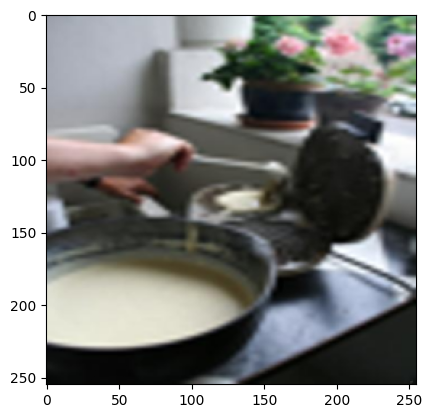

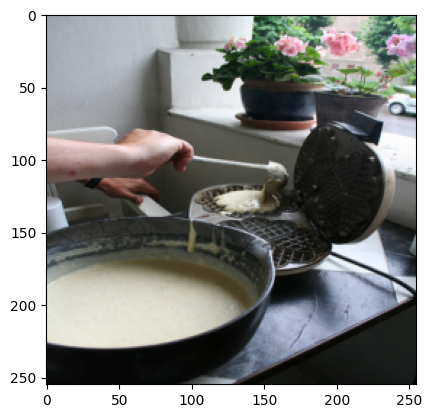

In [4]:
# Make sure images are correct
def imshow(img_tensor):
    # Convert from tensor to numpy array
    np_img = img_tensor.numpy()
    # Change from (C, H, W) to (H, W, C) for visualization
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels
data_iter = iter(data_loader)
paired_images = next(data_iter)

lowres_images, highres_images = paired_images

# Visualize images in the batch
imshow(lowres_images[0])  # Low-res image
imshow(highres_images[0])  # High-res image

In [5]:
# Split the dataset into train and validation
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

print(f"Total Images: {2 * len(dataset)}")
print(f"Training Images: {2 * len(train_dataset)}")
print(f"Validation Images: {2 * len(valid_dataset)}")


Total Images: 2274
Training Images: 1818
Validation Images: 456


In [6]:
import torch.nn as nn
import torch.nn.functional as F

## SRCNN

In [7]:
# SRCNN

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)  # Patch extraction
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)  # Non-linear mapping
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)   # Reconstruction

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = SRCNN()


### Loss Function and Optimizer

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

### Train the Model

In [ ]:
epochs = 1

for epoch in range(epochs):
    model.train()
    counter = 0
    for paired_images in data_loader:
        counter += 1
        print(counter)
        low_res, high_res = paired_images
        low_res = low_res[0]
        high_res = high_res[0]

        optimizer.zero_grad()
        output = model(lowres_images)

        loss = criterion(output, high_res)
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

## SRGAN

In [9]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        return torch.cat([x, out], 1)

class RRDB(nn.Module):
    def __init__(self, in_channels=64, growth_rate=32, num_layers=3):
        super(RRDB, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.lff = nn.Conv2d(in_channels + num_layers * growth_rate, in_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        for layer in self.layers:
            x = layer(x)
        out = self.lff(x)
        return out + residual

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.initial_layer = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.rrdb1 = RRDB()
        self.rrdb2 = RRDB()
        self.rrdb3 = RRDB()

        self.final_layer = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = nn.functional.relu(self.initial_layer(x))

        x = self.rrdb1(x)
        x = self.rrdb2(x)
        x = self.rrdb3(x)

        x = self.final_layer(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_channels, out_channels, normalization=True):
            layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(3, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.AdaptiveAvgPool2d(1)
        )

        self.final_shit = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        out = self.model(img)
        out = torch.flatten(out, 1)
        out = self.final_shit(out)
        return out

generator = Generator()
discriminator = Discriminator()

### Loss Functions & Optimizers

In [15]:
criterion = torch.nn.BCELoss()
generator_mse_loss = torch.nn.MSELoss()

optimizer_g = torch.optim.AdamW(generator.parameters(), lr = 0.001)
optimizer_d = torch.optim.AdamW(discriminator.parameters(), lr = 0.001)


In [16]:
def plot(d_losses, g_losses, d_accuracies, g_accuracies):
    plt.clf()
    plt.figure(figsize=(12, 10))
    batches = range(1, len(d_losses) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(batches, d_accuracies, label='Discriminator Accuracy', color='blue')
    plt.plot(batches, g_accuracies, label='Generator Accuracy', color='red')
    plt.title('Discriminator and Generator Accuracies over Batches')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(batches, [d_loss.detach() for d_loss in d_losses], label='Discriminator Loss', color='green') # Numpy gets mad when not detached
    plt.plot(batches, [g_loss.detach() for g_loss in g_losses], label='Generator Loss', color='orange')
    plt.title('Discriminator and Generator Losses Per Batch')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Train the Model

In [17]:
epochs = 1
cur_batch = 0
d_losses = []
g_losses = []
d_accuracies = []
g_accuracies = []

for epoch in range(epochs):
    for low_res, high_res in data_loader:
        cur_batch += 1
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()
        batch_size = high_res.size(0)
        real_labels = torch.ones(batch_size)
        fake_labels = torch.zeros(batch_size)

        # Real
        real_out = discriminator(high_res).squeeze()
        real_loss = criterion(real_out, real_labels)

        # Fake
        fake_gen = generator(low_res)
        fake_out = discriminator(fake_gen).squeeze()
        fake_loss = criterion(fake_out, fake_labels)

        # D optim
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Detach fake_gen and forward through discriminator again in order to create two seperate computation graphs
        fake_gen_detached = fake_gen.detach()
        fake_out = discriminator(fake_gen_detached).squeeze()

        # G optim
        g_loss = criterion(fake_out, real_labels)
        g_loss.backward()

        g_mse_loss = generator_mse_loss(fake_gen, high_res)
        g_mse_loss.backward()

        optimizer_g.step()

        d_losses.append(d_loss)
        g_losses.append(g_loss)
        g_losses.append(g_mse_loss)

        # Metrics
        d_accuracies.append((real_out > 0.5).sum().item() / batch_size * 100)
        g_accuracies.append((fake_out > 0.5).sum().item() / batch_size * 100)
        print(f"Batch {cur_batch} done!")
        if cur_batch != 1:
            plot(d_losses, g_losses, d_accuracies, g_accuracies)




RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.